In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d_pcsaft import dft_core
from cdft.pcsaft_eos import pcsaft

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')

In [2]:
m = torch.tensor([1.0])
sigma = torch.tensor([3.7039])
epsilon = torch.tensor([150.03])
parameters = {'m':m, 'sigma':sigma, 'epsilon':epsilon}

In [3]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.13/site-packages/pymatgen/io/cif.py:1290: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
T = 300.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters, T, system_size, points, device)

In [5]:
forcefield = pd.DataFrame()
forcefield['type'] = ['C','H','O','Zn']
forcefield['sigma'] = np.array([3.47299, 2.84642, 3.03315, 4.04468])
forcefield['epsilon'] = np.array([47.8562, 7.64893, 48.1581, 27.6771])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

rc = 12.9

Vext = torch.zeros((dft.Nc, points[0], points[1], points[2]),device=device)
U = torch.zeros_like(dft.X)
for i in range(dft.Nc):
    for k, site in enumerate(structure):
        sigmas = float(forcefield['sigma'][forcefield['type']==site.species_string].values[0])
        epsilons = float(forcefield['epsilon'][forcefield['type']==site.species_string].values[0])
        sigmasf = 0.5*(sigma[i]+sigmas) 
        epsilonsf = np.sqrt(epsilon[i].numpy()*epsilons)
        rx = dft.X-structure.cart_coords[k,0] 
        ry = dft.Y-structure.cart_coords[k,1] 
        rz = dft.Z-structure.cart_coords[k,2] 
        rx -= system_size[0]*(rx/system_size[0]).round()
        ry -= system_size[1]*(ry/system_size[1]).round()
        rz -= system_size[2]*(rz/system_size[2]).round()
        r = torch.sqrt(rx**2+ry**2+rz**2)
        U = lj_potential(r,sigmasf,epsilonsf)
        U[r==0] = np.inf
        U[r>rc] = 0.0
        Vext[i] += U

Text(0, 0.5, '$y$ (\\AA{})')

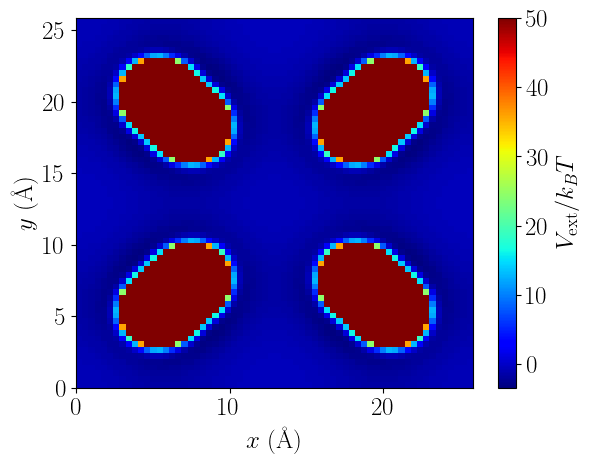

In [6]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[0,:,:,points[2]//2].cpu()/T, vmax=50.0, cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [7]:
P = torch.hstack((torch.arange(1e4,1e5,1e4), torch.arange(1e5,1e6,1e5), torch.range(1e6,1e7,1e6)))
bulk_density = torch.empty_like(P)
composition = torch.tensor([1.0])

eos = pcsaft(parameters, T)
bulk_density[0] = eos.density(P[0],composition,'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],composition,bulk_density[i-1])

/tmp/ipykernel_14145/373484605.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  P = torch.hstack((torch.arange(1e4,1e5,1e4), torch.arange(1e5,1e6,1e5), torch.range(1e6,1e7,1e6)))


In [8]:
dft.initial_condition(bulk_density[0],composition,Vext)
Nads = torch.empty((dft.Nc,len(P)))
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],composition,fmt='ASWB',solver='anderson',
                                    anderson_mmax=10,anderson_damping=0.2,tol=1e-6,logoutput=False)
    for j in range(dft.Nc):
        Nads[j,i] = dft.total_molecules[j]
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[:,i].numpy())
    if np.isnan(dft.error.numpy()): break

5 2.173522103651173e-07 0.1 [0.27496799]
6 3.0093825845576966e-07 0.2 [0.55060212]
6 7.237100415953993e-08 0.30000000000000004 [0.82689494]
5 6.983253460494549e-07 0.4 [1.10383871]
5 3.6728170777679125e-07 0.5 [1.38142431]
5 2.1734947080866226e-07 0.6000000000000001 [1.65964438]
5 1.3187733133962717e-07 0.7000000000000001 [1.93849052]
5 7.648118758069154e-08 0.8 [2.21795417]
5 3.792113358569196e-08 0.9 [2.49802664]
5 1.6176027328919514e-08 1.0 [2.77869904]
8 4.251706144018699e-07 2.0 [5.61634839]
7 4.350291888645276e-07 3.0000000000000004 [8.50303181]
7 6.122033629828479e-07 4.0 [11.42732727]
8 2.494471893009464e-07 5.0 [14.37663727]
8 1.3408259169705425e-07 6.000000000000001 [17.33762218]
8 1.0564789303391605e-07 7.000000000000001 [20.29667421]
8 9.760484876440701e-08 8.0 [23.24048651]
8 1.2889282052985378e-07 9.0 [26.1565415]
8 2.634637179945423e-07 10.0 [29.0335131]
18 4.251982664071878e-07 20.0 [54.22584468]
16 1.811130760094521e-07 30.000000000000004 [72.27209204]
16 2.62822218279

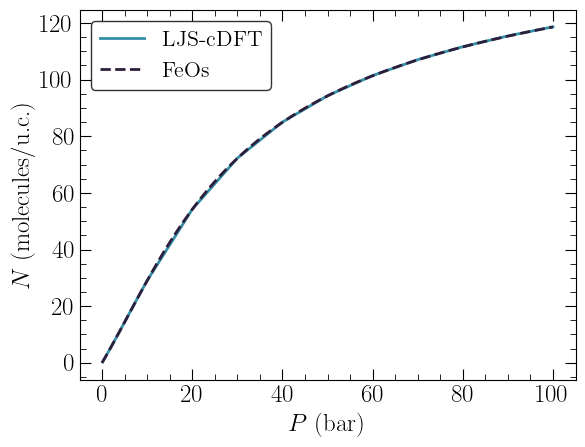

In [9]:
# data = pd.read_pickle(f'data/methane_IRMOF-1_{T:.2f}K.pkl')
feos = np.load('data/feos.npy')

import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P*1e-5, Nads[0], '-', color=colors[3], linewidth=2.0, label='LJS-cDFT')
plt.plot(feos[0], feos[1], '--', color=colors[0], linewidth=2.0, label='FeOs')
# plt.plot(1e-5*data['Pressure (Pa)'], data['Absolute adsorption (molecules/uc)'], 'o', 
#          color=colors[3],markersize=7,markeredgewidth=1.5,mfc='none',label='GCMC')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,125])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')